In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from fishsense_imwut.camera import reconstruct_points

## Setup of Simulation
The following reasonable defaults that match the systems we tested against.

In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT = 4014, 3016
FOCAL_LENGTH_PX = 2850

IMAGE_WIDTH, IMAGE_HEIGHT, FOCAL_LENGTH_PX

(4014, 3016, 2850)

In [3]:
camera_intrinsics = np.array([
    [FOCAL_LENGTH_PX, 0, IMAGE_WIDTH / 2],
    [0, FOCAL_LENGTH_PX, IMAGE_HEIGHT / 2],
    [0, 0, 1]
])
inverted_camera_intrinsics = np.linalg.inv(camera_intrinsics)

camera_intrinsics, inverted_camera_intrinsics

(array([[2.850e+03, 0.000e+00, 2.007e+03],
        [0.000e+00, 2.850e+03, 1.508e+03],
        [0.000e+00, 0.000e+00, 1.000e+00]]),
 array([[ 3.50877193e-04,  0.00000000e+00, -7.04210526e-01],
        [ 0.00000000e+00,  3.50877193e-04, -5.29122807e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [4]:
laser_position = np.array([-0.04, -0.11, 0])
laser_direction = np.array([1e-10, 1e-10, 1])

laser_params = np.concatenate([laser_direction, laser_position[:2]])

laser_position, laser_direction, laser_params

(array([-0.04, -0.11,  0.  ]),
 array([1.e-10, 1.e-10, 1.e+00]),
 array([ 1.0e-10,  1.0e-10,  1.0e+00, -4.0e-02, -1.1e-01]))

## Next we setup data we can use for testing

In [5]:
STEP_COUNT = 1000
t = np.linspace(0.5, 30, STEP_COUNT)

STEP_COUNT, t

(1000,
 array([ 0.5       ,  0.52952953,  0.55905906,  0.58858859,  0.61811812,
         0.64764765,  0.67717718,  0.70670671,  0.73623624,  0.76576577,
         0.7952953 ,  0.82482482,  0.85435435,  0.88388388,  0.91341341,
         0.94294294,  0.97247247,  1.002002  ,  1.03153153,  1.06106106,
         1.09059059,  1.12012012,  1.14964965,  1.17917918,  1.20870871,
         1.23823824,  1.26776777,  1.2972973 ,  1.32682683,  1.35635636,
         1.38588589,  1.41541542,  1.44494494,  1.47447447,  1.504004  ,
         1.53353353,  1.56306306,  1.59259259,  1.62212212,  1.65165165,
         1.68118118,  1.71071071,  1.74024024,  1.76976977,  1.7992993 ,
         1.82882883,  1.85835836,  1.88788789,  1.91741742,  1.94694695,
         1.97647648,  2.00600601,  2.03553554,  2.06506507,  2.09459459,
         2.12412412,  2.15365365,  2.18318318,  2.21271271,  2.24224224,
         2.27177177,  2.3013013 ,  2.33083083,  2.36036036,  2.38988989,
         2.41941942,  2.44894895,  2.4784784

In [6]:
p = laser_position[:, np.newaxis] + t[np.newaxis, :] * laser_direction[:, np.newaxis]

p

array([[-0.04      , -0.04      , -0.04      , ..., -0.04      ,
        -0.04      , -0.04      ],
       [-0.11      , -0.11      , -0.11      , ..., -0.11      ,
        -0.11      , -0.11      ],
       [ 0.5       ,  0.52952953,  0.55905906, ..., 29.94094094,
        29.97047047, 30.        ]], shape=(3, 1000))

In [7]:
s = p / p[2, :]
s = camera_intrinsics @ s

s

array([[1.77900000e+03, 1.79171456e+03, 1.80308594e+03, ...,
        2.00319250e+03, 2.00319626e+03, 2.00320000e+03],
       [8.81000000e+02, 9.15965029e+02, 9.47236348e+02, ...,
        1.49752939e+03, 1.49753970e+03, 1.49755000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], shape=(3, 1000))

In [8]:
s_pixel = np.round(s)

s_pixel

array([[1.779e+03, 1.792e+03, 1.803e+03, ..., 2.003e+03, 2.003e+03,
        2.003e+03],
       [8.810e+02, 9.160e+02, 9.470e+02, ..., 1.498e+03, 1.498e+03,
        1.498e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 1000))

In [ ]:
import numpy as np
from scipy.optimize import least_squares

def project_point(K, X):
    """Project a 3D point X (camera frame) to pixel coords (u,v)."""
    x, y, z = X
    if z <= 1e-9:
        # behind/too close; return huge residuals
        return np.array([1e9, 1e9], dtype=float)
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    u = fx * (x / z) + cx
    v = fy * (y / z) + cy
    return np.array([u, v], dtype=float)

def estimate_point_on_line_from_pixel(u_obs, K, P, D, sigma_px=1.0, t_init=0.0, bounds=None):
    """
    u_obs: (2,) observed pixel
    K: 3x3 intrinsics
    P: (3,) point on 3D line (camera frame)
    D: (3,) unit direction of 3D line (camera frame)
    sigma_px: pixel std dev (assumes isotropic Gaussian)
    t_init: initial guess for t
    bounds: optional (t_min, t_max) to enforce Z>0 region, etc.

    Returns: X_hat (3,), t_hat, reprojection_error_pixels
    """
    u_obs = np.asarray(u_obs, float)
    P = np.asarray(P, float)
    D = np.asarray(D, float)
    D = D / np.linalg.norm(D)

    def residual(t_scalar):
        t = float(t_scalar[0])
        X = P + t * D
        u_pred = project_point(K, X)
        r = (u_obs - u_pred) / sigma_px
        return r

    if bounds is None:
        res = least_squares(residual, x0=np.array([t_init], float), method="trf")
    else:
        tmin, tmax = bounds
        res = least_squares(residual, x0=np.array([t_init], float), bounds=(tmin, tmax), method="trf")

    t_hat = float(res.x[0])
    X_hat = P + t_hat * D
    u_pred = project_point(K, X_hat)
    reproj_err = float(np.linalg.norm(u_obs - u_pred))
    return X_hat, t_hat, reproj_err

In [21]:
np.random.seed(0)

calibrations_by_stds = []
stds = [
    (0.0, 0.0),
    (0.5, 0.5),
    (1.0, 1.0),
    (2.0, 2.0),
    (3.0, 5.0), # Real world estimate
    (5.0, 5.0),
    (8.0, 8.0),
    (10.0, 10.0),
]

z_errors_by_stds = []
for idx, (x_std, y_std) in enumerate(stds):
    s_noisy = s.copy()
    s_noisy[0, :] += np.random.normal(0, x_std, s.shape[1])
    s_noisy[1, :] += np.random.normal(0, y_std, s.shape[1])

    p_reconstructed = reconstruct_points(s_noisy, inverted_camera_intrinsics, laser_position, laser_direction)

    p_final = np.zeros_like(p_reconstructed)
    if x_std == 0.0 and y_std == 0.0:
        p_final = p_reconstructed
    else:
        for i in range(s_noisy.shape[1]):
            t = (p_reconstructed[:, i] - laser_position) @ laser_direction

            u_obs = s_noisy[:2, i]
            X_hat, t_hat, reproj_err = estimate_point_on_line_from_pixel(
                u_obs,
                camera_intrinsics,
                laser_position,
                laser_direction,
                sigma_px=y_std,
                t_init=t,
            )
            p_final[:, i] = X_hat

    z_error = np.abs(p_final[2, :] - p[2, :]) / p[2, :] * 100
    z_errors_by_stds.append(((x_std, y_std), z_error))

/tmp/ipykernel_3368455/1491506354.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds])


Text(0, 0.5, 'Z Percent Error (%)')

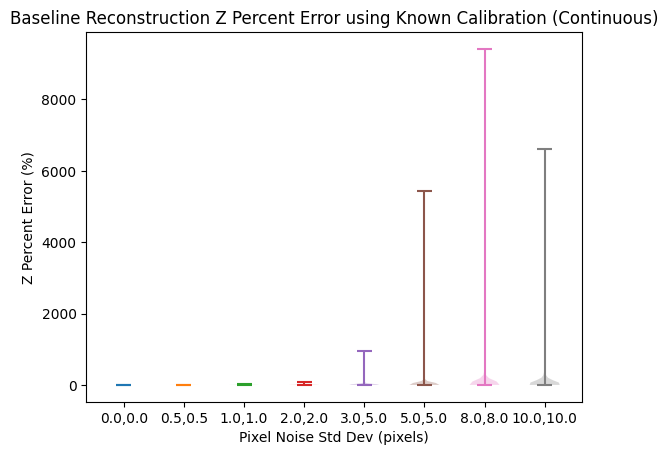

In [22]:
fig, ax = plt.subplots()

for idx, ((x_std, y_std), z_error) in enumerate(z_errors_by_stds):
    ax.violinplot(z_error, positions=[idx])

ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds])
ax.set_title("Baseline Reconstruction Z Percent Error using Known Calibration (Continuous)")
ax.set_xlabel("Pixel Noise Std Dev (pixels)")
ax.set_ylabel("Z Percent Error (%)")

/tmp/ipykernel_3368455/2763300334.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds[:4]])


Text(0, 0.5, 'Z Percent Error (%)')

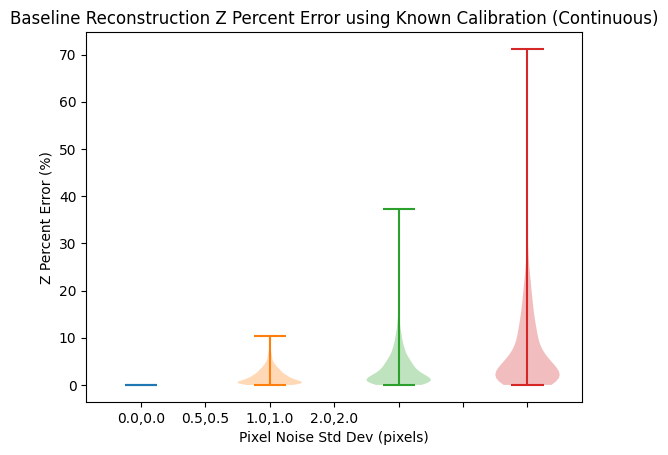

In [24]:
fig, ax = plt.subplots()

for idx, ((x_std, y_std), z_error) in enumerate(z_errors_by_stds[:4]):
    ax.violinplot(z_error, positions=[idx])

ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds[:4]])
ax.set_title("Baseline Reconstruction Z Percent Error using Known Calibration (Continuous)")
ax.set_xlabel("Pixel Noise Std Dev (pixels)")
ax.set_ylabel("Z Percent Error (%)")